# Introduction

## Short description of the problem

We consider a vacuum vessel embodied as a toroidal volume defined by a 2D arbitrary polygon representing in cross-section in (R,Z) coordinates.
We want to efficiently mesh both the volume and the 3D surface of the vessel.

As input, we provide the cross-section polygon and a list dV defining the three resolutions dV = [dR,dZ,dRphi], where each resolution is a distance in meters in the corresponding direction (note the use of dRphi instead of dphi for that purpose).
Indeed, we do not want a simple cylindrical mesh, as we want to capture details in the toroidal (Rphi) direction with a similar accuracy for every value of R.

In most uses, we will only need a fraction of the total mesh. Hence, the routine should not compute the total mesh but only the fraction we need.
For a given resolution dV (i.e. a given tuple of dR,dZ,dRphi), there should be only one possible mesh.
This way, the fraction of interest can be defined either by its physical limits (DR,DZ,DPhi) or by the indices of the mesh elements which are required. 

Hence, we need a methods to 
* Compute the mesh fraction from its limits and return it with its indices
* Compute the mesh fraction from its indices and return it with its limits

Not returning the whole mesh makes sense since it may well be a huge array (memory-expensive). The computation should be as fast as possible.


## Numerical strategy

### Volume

For a given input cross-section polygon VPoly, provided with the required resolutions dR, dZ and dRphi, the total mesh is a torus of rectangular cross-section (R goes from a minimum to a maximum, as Z, and phi goes from -pi to pi). This simplifies the computation of the indices without making the result heavier since only the relevant mesh elements are returned.
The limits of the desired submesh can be provided as DR, DZ and DPhi (note that the toroidal limit is angular as opposed to the toroidal resolution).

The minimum and maximim boundaries of R and Z are also provided. They could be deduced from VPOly but they are explicitly provided for two reasons:
* In ToFu these limits are stored in the Ves object, so it is already available and there is no need to compute it again
* It may happen that a VPoly is slightly modified with no desire to modify the mesh, so it should remain possible to force the boundaries.

The indices are return in numeric form (not boolean), and computed as follows:
* The numbering occurs anti-clockwise from -pi to pi for phi
* Then, it occurs along Z, from its minimum to its maximum value
* Finally it is incremented along R, from its minimum to its maximum value

Hence, we first describe the innermost column (starting from the lowest horizontal ring), and we gradually moved towards the outermost column.

This is necessary since due the desired quasi-constant toroidal accuracy, the number of mesh elements in the toroidal direction is a function of R. 


### Surface

The strategy for meshing the surface is similar, expect that here there are only two resolutions, dL and dRPhi, where dL is the resolution in the poloidal direction along the segments of VPoly.

## Volume meshing 

### Naive python

In [4]:
A = np.random.random((100,))
%timeit len(A)
%timeit A.size

The slowest run took 44.64 times longer than the fastest. This could mean that an intermediate result is being cached.
10000000 loops, best of 3: 90.8 ns per loop
The slowest run took 36.53 times longer than the fastest. This could mean that an intermediate result is being cached.
10000000 loops, best of 3: 111 ns per loop


### Numpy

In [55]:
10%2

0

In [2]:
import numpy as np

# Preliminary function to get optimal resolution from input resolution
def _Ves_mesh_dlfromL_numpy(LMinMax, dL, DL=None, margin=1.e-9):
    """ Get the actual reolution from the desired resolution and MinMax and limits """
    # Get the number of mesh elements in LMinMax
    N = np.ceil(np.diff(LMinMax)/dL)[0]
    # Derive the real (effective) resolution
    dLr = (np.diff(LMinMax)/N)[0]
    # Get desired limits if any
    DL = LMinMax if DL is None else DL
    # Get the extreme indices of the mesh elements that really need to be created within those limits
    abs0 = np.abs(DL[0]-LMinMax[0])
    if abs0-dLr*np.floor(abs0/dLr)<margin*dLr:
        nL0 = np.round((DL[0]-LMinMax[0])/dLr)
    else:
        nL0 = np.floor((DL[0]-LMinMax[0])/dLr)
    abs1 = np.abs(DL[1]-LMinMax[0])
    if abs1-dLr*np.floor(abs1/dLr)<margin*dLr:
        nL1 = np.round((DL[1]-LMinMax[0])/dLr)-1
    else:
        nL1 = np.floor((DL[1]-LMinMax[0])/dLr)
    # Get the corresponding indices
    indL = np.arange(nL0,nL1+1,1).astype(int)
    # Get the centers of the mesh elements
    L = LMinMax[0] + (0.5 + indL)*dLr
    return L, dLr, indL, N


def _Ves_Vmesh_Phi_numpy(DPhi, dPhir, NRPhi, margin=1.e-9):
    """ Get the min and max indices of the relevant Phi for each R (to be finished) """
    nPhi0 = np.nan*np.ones((dPhir.size,))
    nPhi1 = np.nan*np.ones((dPhir.size,))
    abs0 = np.abs(DPhi[0]+np.pi)
    ind0 = abs0-dPhir*np.floor(abs0/dPhir)<margin*dPhir
    nPhi0[ind0] = np.round((DPhi[0]+np.pi)/dPhir[ind0])
    nPhi0[~ind0] = np.floor((DPhi[0]+np.pi)/dPhir[~ind0])
    abs1 = np.abs(DPhi[1]+np.pi)
    ind1 = abs1-dPhir*np.floor(abs1/dPhir)<margin*dPhir
    nPhi1[ind1] = np.round((DPhi[1]+np.pi)/dPhir[ind1])-1
    nPhi1[~ind1] = np.floor((DPhi[1]+np.pi)/dPhir[~ind1])
    assert np.all(nPhi0>=0) and np.all(nPhi0<=NRPhi)
    assert np.all(nPhi1>=0) and np.all(nPhi1<=NRPhi)
    return nPhi0, nPhi1


def _Ves_Vmesh_Tor_SubFromD_numpy(dR, dZ, dRPhi, RMinMax, ZMinMax, DR=None, DZ=None, DPhi=None, VPoly=None, Out='(X,Y,Z)', margin=1.e-9):
    """ Return the desired submesh indicated by the limits (DR,DZ,DPhi), for the desired resolution (dR,dZ,dRphi) """
    # Get the actual R and Z resolutions and mesh elements
    R0, dRr0, indR0, NR0 = _Ves_mesh_dlfromL_numpy(RMinMax, dR, None, margin=margin)
    R, dRr, indR, NR = _Ves_mesh_dlfromL_numpy(RMinMax, dR, DR, margin=margin)
    Z, dZr, indZ, NZ = _Ves_mesh_dlfromL_numpy(ZMinMax, dZ, DZ, margin=margin)
    Rn, Zn = len(R), len(Z)

    # Get the actual RPhi resolution and Phi mesh elements (! depends on R !)
    NRPhi0 = np.ceil(2.*np.pi*R0/dRPhi)
    NRPhi = np.ceil(2.*np.pi*R/dRPhi)
    dPhir = 2.*np.pi/NRPhi
    # Get the limits if any (and make sure to replace them in the proper quadrants)
    DPhi = [-np.pi,np.pi] if DPhi is None else np.arctan2(np.sin(DPhi),np.cos(DPhi))
    # Later we'll have to remember that the lower limit may be greater than the upper limit due to 2pi modulo
    # Get the two extreme indices of the Phi elements inside the limits for each R
    nPhi0, nPhi1 = _Ves_Vmesh_Phi_numpy(DPhi, dPhir, NRPhi, margin=margin)

    # Compute the centers and indices, using a for loop (no choice) on R
    NRZPhi_cum0 = np.concatenate(([0],NZ*np.cumsum(NRPhi0[:-1])))
    PtsRZP, dV, ind = [], [], []
    for ii in range(0,Rn):
        # Get the phi values
        if DPhi[0]<DPhi[1]:
            indPhi = np.arange(nPhi0[ii],nPhi1[ii]+1)
        else:
            indPhi = np.concatenate((np.arange(nPhi0[ii],NRPhi[ii]),np.arange(0,nPhi1[ii]+1)))
        Phin = len(indPhi)
        phi = -np.pi + (0.5 + indPhi)*dPhir[ii]
        # Get the (R,Z,phi) points
        PtsRZP.append( np.array([R[ii]*np.ones((Phin*Zn,)), np.repeat(Z,Phin), np.tile(phi,Zn)]) )
        # Get the volume
        dV.append( dRr*dZr*dPhir[ii]*R[ii]*np.ones((Phin*Zn,))  )
        # Get the indices
        indii = R0==R[ii]
        ind.append( NRZPhi_cum0[indii] + (indZ[:,np.newaxis]*NRPhi[ii] + indPhi[np.newaxis,:]).flatten() )
        
    PtsRZP = np.concatenate(tuple(PtsRZP),axis=1)
    dV = np.concatenate(tuple(dV))
    ind = np.concatenate(tuple(ind))
    
    # To be commented out once debugged
    assert ind.size==PtsRZP.shape[1]
    assert ind.size==dV.size
    assert np.unique(ind).size==ind.size 

    dRPhir = (dPhir*R)
    """
    if not VPoly is None:
        indin = _Ves_isInside(VPoly, 'Tor', None, PtsRZP[:-1,:], In='(R,Z)')
        PtsRZP, dV, ind = PtsRZP[:,indin], dV[indin], ind[indin]
        Ru = np.unique(PtsRZP[0,:])
        if not Ru==R:
            indii = np.array([R[ii] in Ru for ii in range(0,len(R))], dtype=bool)
            dRPhir = dRPhir[indii]
    """

    if Out.lower()=='(x,y,z)':
        Pts = np.array([PtsRZP[0,:]*np.cos(PtsRZP[2,:]), PtsRZP[0,:]*np.sin(PtsRZP[2,:]), PtsRZP[1,:]])
    else:
        Pts = PtsRZP
        
    return Pts, dV, ind, dRr, dZr, dRPhir

def _Ves_Vmesh_Tor_SubFromInd_numpy(dR, dZ, dRPhi, RMinMax, ZMinMax, ind, Out='(X,Y,Z)', margin=1.e-9):
    """ Return the desired submesh indicated by the (numerical) indices, for the desired resolution (dR,dZ,dRphi) """
    # Get the actual R and Z resolutions and mesh elements
    R, dRr, indR, NR = _Ves_mesh_dlfromL_numpy(RMinMax, dR, None, margin=margin)
    Z, dZr, indZ, NZ = _Ves_mesh_dlfromL_numpy(ZMinMax, dZ, None, margin=margin)
    Rn, Zn = len(R), len(Z)

    # Get the actual RPhi resolution and Phi mesh elements (! depends on R !)
    NRPhi = np.ceil(2.*np.pi*R/dRPhi)
    dPhir = 2.*np.pi/NRPhi
    NRZPhi_cum = np.concatenate(([0],NZ*np.cumsum(NRPhi[:-1])))
    
    # Get R, Z, and Phi indices
    Nind = ind.size
    indR = ind[:,np.newaxis]-NRZPhi_cum[np.newaxis,:]<0
    indRtemp = np.tile(np.arange(0,NR),(Nind,1))
    indRtemp[indR] = np.nan
    indR = np.nanmax(indRtemp, axis=1).astype(int)
    indZ = ((ind - NRZPhi_cum[indR]) // NRPhi[indR]).astype(int)
    indPhi = ind - NRZPhi_cum[indR] - indZ*NRPhi[indR]
    
    # Derive R, Z and phi values
    PtsRZP = np.array([R[indR], Z[indZ], np.nan*np.ones((Nind,))])
    dV = np.nan*np.ones((Nind,))
    Ru = np.unique(PtsRZP[0,:])
    dRPhir = np.nan*np.ones((len(Ru),))
    for ii in range(0,len(Ru)):
        indRii = R==Ru[ii]
        indRu = PtsRZP[0,:]==Ru[ii]
        PtsRZP[2,indRu] = -np.pi + (0.5+indPhi[indRu])*dPhir[R==Ru[ii]]
        dRPhir[ii] = dPhir[indRii]*Ru[ii]
        dV[indRu] = dRr*dZr*dRPhir[ii]
        
    if Out.lower()=='(x,y,z)':
        Pts = np.array([PtsRZP[0,:]*np.cos(PtsRZP[2,:]), PtsRZP[0,:]*np.sin(PtsRZP[2,:]), PtsRZP[1,:]])
    else:
        Pts = PtsRZP

    return Pts, dV, dRr, dZr, dRPhir



### Check and debug

In [2]:
# Check and debug
[dR, dZ, dRPhi], RMinMax, ZMinMax = [0.03]*3, [2.,3.], [-1.,1.]
DR, DZ, DPhi = [2.15,2.6], [-0.21,0.51], [7.*np.pi/4.,5.*np.pi/4.]

Pts0, dV0, ind0, dRr0, dZr0, dRPhir0 = _Ves_Vmesh_Tor_SubFromD_numpy(dR,dZ,dRPhi, RMinMax,ZMinMax, Out='(X,Y,Z)')
PtsRZP0 = np.array([np.hypot(Pts0[0,:],Pts0[1,:]), Pts0[2,:],np.arctan2(Pts0[1,:],Pts0[0,:])])
Pts0b, dV0b, dRr0b, dZr0b, dRPhir0b = _Ves_Vmesh_Tor_SubFromInd_numpy(dR, dZ, dRPhi, RMinMax, ZMinMax, ind0, Out='(X,Y,Z)')
print "Check 0", [np.allclose(Pts0,Pts0b,atol=1.e-14,rtol=0.,equal_nan=True) for (A,B) in [(Pts0,Pts0b),(dV0,dV0b),(dRr0,dRr0b),(dZr0,dZr0b),(dRPhir0,dRPhir0b)]]

Pts, dV, ind, dRr, dZr, dRPhir = _Ves_Vmesh_Tor_SubFromD_numpy(dR,dZ,dRPhi, RMinMax,ZMinMax, DR=DR,DZ=DZ,DPhi=DPhi, Out='(X,Y,Z)')
PtsRZP = np.array([np.hypot(Pts[0,:],Pts[1,:]), Pts[2,:],np.arctan2(Pts[1,:],Pts[0,:])])
Ptsb, dVb, dRrb, dZrb, dRPhirb = _Ves_Vmesh_Tor_SubFromInd_numpy(dR,dZ,dRPhi, RMinMax,ZMinMax, ind, Out='(X,Y,Z)')
print "Check 1", [np.allclose(A,B,atol=1.e-14,rtol=0.,equal_nan=True) for (A,B) in [(Pts,Ptsb),(dV,dVb),(dRr,dRrb),(dZr,dZrb),(dRPhir,dRPhirb)]]

Check 0 [True, True, True, True, True]
Check 1 [True, True, True, True, True]


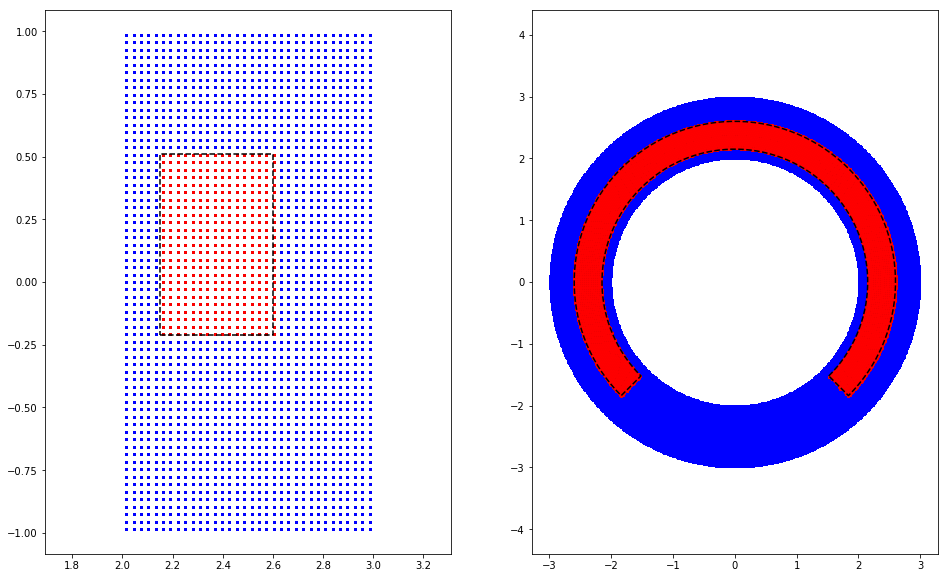

In [3]:
# Plot for check and debug
import matplotlib.pyplot as plt

plt.figure(figsize=(16,10))
plt.subplot(1,2,1, aspect="equal", adjustable="datalim")
plt.plot(PtsRZP0[0,:],PtsRZP0[1,:],'.b', PtsRZP[0,:],PtsRZP[1,:],'.r', markersize=2)
plt.plot([DR[0],DR[1],DR[1],DR[0],DR[0]], [DZ[0],DZ[0],DZ[1],DZ[1],DZ[0]],'--k')

plt.subplot(1,2,2, aspect="equal", adjustable="datalim")
plt.plot(Pts0[0,:],Pts0[1,:],'.b', Pts[0,:],Pts[1,:],'.r', markersize=2)
thet = np.linspace(DPhi[0],DPhi[1],100) if DPhi[0]<DPhi[1] else np.linspace(DPhi[0],DPhi[1]+2.*np.pi,100)
X = np.concatenate((DR[0]*np.cos(thet),DR[1]*np.cos(thet[::-1]),[DR[0]*np.cos(thet[0])]))
Y = np.concatenate((DR[0]*np.sin(thet),DR[1]*np.sin(thet[::-1]),[DR[0]*np.sin(thet[0])]))
plt.plot(X,Y,'--k')

plt.show()

In [5]:
# Check and debug
[dR, dZ, dRPhi], RMinMax, ZMinMax = [0.02]*3, [2.,3.], [-1.,1.]
DR, DZ, DPhi = [2.15,2.6], [-0.21,0.51], [7.*np.pi/4.,5.*np.pi/4.]
Pts0, dV0, ind0, dRr0, dZr0, dRPhir0 = _Ves_Vmesh_Tor_SubFromD_numpy(dR,dZ,dRPhi, RMinMax,ZMinMax, Out='(X,Y,Z)')

%timeit out = _Ves_Vmesh_Tor_SubFromD_numpy(dR,dZ,dRPhi, RMinMax,ZMinMax, Out='(X,Y,Z)')
%timeit out = _Ves_Vmesh_Tor_SubFromInd_numpy(dR, dZ, dRPhi, RMinMax, ZMinMax, ind0, Out='(X,Y,Z)')

1 loop, best of 3: 665 ms per loop
1 loop, best of 3: 5.15 s per loop


### Cython

In [3]:
%load_ext cython

In [26]:
%%cython -a
cimport cython
import numpy as np
cimport numpy as cnp
from cpython cimport bool
from libc.math cimport ceil as Cceil, abs as Cabs, floor as Cfloor, round as Cround
from libc.math cimport cos as Ccos, sin as Csin, atan2 as Catan2, pi as Cpi

import datetime as dtm

# Preliminary function to get optimal resolution from input resolution
@cython.cdivision(True)
@cython.wraparound(False)
@cython.boundscheck(False)
def _Ves_mesh_dlfromL_cython(double[::1] LMinMax, double dL, DL=None, double margin=1.e-9):
    """ Get the actual reolution from the desired resolution and MinMax and limits """
    # Get the number of mesh elements in LMinMax
    cdef double N = Cceil((LMinMax[1]-LMinMax[0])/dL)
    # Derive the real (effective) resolution
    cdef double dLr = (LMinMax[1]-LMinMax[0])/N
    # Get desired limits if any
    cdef double[::1] DLc, L
    cdef long [::1] indL
    #cdef cnp.ndarray[double,ndim=1] indL, L
    cdef double abs0, abs1, A
    cdef int nL0, nL1, Nind, ii, jj
    if DL is None:
        DLc = LMinMax
    else:
        DLc = DL
    # Get the extreme indices of the mesh elements that really need to be created within those limits
    abs0 = Cabs(DLc[0]-LMinMax[0])
    if abs0-dLr*Cfloor(abs0/dLr)<margin*dLr:
        nL0 = int(Cround((DLc[0]-LMinMax[0])/dLr))
    else:
        nL0 = int(Cfloor((DLc[0]-LMinMax[0])/dLr))
    abs1 = Cabs(DLc[1]-LMinMax[0])
    if abs1-dLr*Cfloor(abs1/dLr)<margin*dLr:
        nL1 = int(Cround((DLc[1]-LMinMax[0])/dLr)-1)
    else:
        nL1 = int(Cfloor((DLc[1]-LMinMax[0])/dLr))
    # Get the corresponding indices
    Nind = nL1+1-nL0
    indL = np.empty((Nind,),dtype=int)#np.linspace(nL0,nL1,Nind,endpoint=True)
    L = np.empty((Nind,))
    for ii in range(0,Nind):
        jj = nL0+ii
        indL[ii] = jj
        L[ii] = LMinMax[0] + (0.5 + (<double>jj))*dLr
    return np.asarray(L), dLr, np.asarray(indL), N

@cython.cdivision(True)
@cython.wraparound(False)
@cython.boundscheck(False)
def _Ves_Vmesh_Tor_SubFromD_cython(double dR, double dZ, double dRPhi, double[::1] RMinMax, double[::1] ZMinMax,
                                   DR=None, DZ=None, DPhi=None, VPoly=None,
                                   str Out='(X,Y,Z)', double margin=1.e-9):
    " Return the desired submesh indicated by the limits (DR,DZ,DPhi), for the desired resolution (dR,dZ,dRphi) "
    
    cdef double[::1] R0, R, Z, dRPhir, dPhir, NRPhi#, dPhi, NRZPhi_cum0, indPhi, phi
    cdef double dRr0, dRr, dZr, DPhi0, DPhi1
    cdef double abs0, abs1, phi, indiijj
    cdef long[::1] indR0, indR, indZ, Phin, NRPhi0
    cdef int NR0, NR, NZ, Rn, Zn, nRPhi0, indR0ii, ii, jj, nPhi0, nPhi1, zz, NP, NRPhi_int, Rratio
    cdef cnp.ndarray[double,ndim=2] Pts, indI
    cdef cnp.ndarray[double,ndim=1] dV, ind
    
    # Get the actual R and Z resolutions and mesh elements
    R0, dRr0, indR0, NR0 = _Ves_mesh_dlfromL_cython(RMinMax, dR, None, margin=margin)
    R, dRr, indR, NR = _Ves_mesh_dlfromL_cython(RMinMax, dR, DR, margin=margin)
    Z, dZr, indZ, NZ = _Ves_mesh_dlfromL_cython(ZMinMax, dZ, DZ, margin=margin)
    Rn = len(R)
    Zn = len(Z)
    
    # Get the limits if any (and make sure to replace them in the proper quadrants)
    if DPhi is None:
        DPhi0, DPhi1 = -Cpi, Cpi
    else:
        DPhi0, DPhi1 = Catan2(Csin(DPhi[0]),Ccos(DPhi[0])), Catan2(Csin(DPhi[1]),Ccos(DPhi[1]))
    
    dRPhir, dPhir = np.empty((Rn,)), np.empty((Rn,))
    Phin = np.empty((Rn,),dtype=int)
    NRPhi = np.empty((Rn,))
    NRPhi0 = np.zeros((Rn,),dtype=int)
    nRPhi0, indR0ii = 0, 0
    NP, NPhimax = 0, 0
    Rratio = int(Cceil(R[Rn-1]/R[0]))
    for ii in range(0,Rn):
        # Get the actual RPhi resolution and Phi mesh elements (! depends on R !)
        NRPhi[ii] = Cceil(2.*Cpi*R[ii]/dRPhi)
        NRPhi_int = int(NRPhi[ii])
        dPhir[ii] = 2.*Cpi/NRPhi[ii]
        dRPhir[ii] = dPhir[ii]*R[ii]
        # Get index and cumulated indices from background
        for jj in range(indR0ii,NR0):
            if R0[jj]==R[ii]:
                indR0ii = jj
                break
            else:
                nRPhi0 += <long>Cceil(2.*Cpi*R0[jj]/dRPhi)
                NRPhi0[ii] = nRPhi0*NZ
        # Get indices of phi
        # Get the extreme indices of the mesh elements that really need to be created within those limits
        abs0 = Cabs(DPhi0+Cpi)
        if abs0-dPhir[ii]*Cfloor(abs0/dPhir[ii])<margin*dPhir[ii]:
            nPhi0 = int(Cround((DPhi0+Cpi)/dPhir[ii]))
        else:
            nPhi0 = int(Cfloor((DPhi0+Cpi)/dPhir[ii]))
        abs1 = Cabs(DPhi1+Cpi)
        if abs1-dPhir[ii]*Cfloor(abs1/dPhir[ii])<margin*dPhir[ii]:
            nPhi1 = int(Cround((DPhi1+Cpi)/dPhir[ii])-1)
        else:
            nPhi1 = int(Cfloor((DPhi1+Cpi)/dPhir[ii]))
            
        if DPhi0<DPhi1:
            #indI.append(list(range(nPhi0,nPhi1+1)))
            Phin[ii] = nPhi1+1-nPhi0
            if ii==0:
                indI = np.ones((Rn,Phin[ii]*Rratio+1,))
            for jj in range(0,Phin[ii]):
                indI[ii,jj] = <double>( nPhi0+jj )
        else:
            #indI.append(list(range(nPhi0,NRPhi_int)+list(range(0,nPhi1+1))))
            Phin[ii] = nPhi1+1+NRPhi_int-nPhi0
            if ii==0:
                indI = np.ones((Rn,Phin[ii]*Rratio+1,))
            for jj in range(0,NRPhi_int-nPhi0):
                indI[ii,jj] = <double>( nPhi0+jj )
            for jj in range(NRPhi_int-nPhi0,Phin[ii]):
                indI[ii,jj] = <double>( jj- (NRPhi_int-nPhi0) )
        NP += Zn*Phin[ii]   
    
    Pts = np.empty((3,NP))
    ind = np.empty((NP,))
    dV = np.empty((NP,))
    # Compute Pts, dV and ind
    # This triple loop is the longest part, it takes ~90% of the CPU time
    NP = 0
    if Out.lower()=='(x,y,z)':
        for ii in range(0,Rn):
            for zz in range(0,Zn):
                for jj in range(0,Phin[ii]):
                    indiijj = indI[ii,jj]
                    phi = -Cpi + (0.5+indiijj)*dPhir[ii]
                    Pts[0,NP] = R[ii]*Ccos(phi)
                    Pts[1,NP] = R[ii]*Csin(phi)
                    Pts[2,NP] = Z[zz]
                    ind[NP] = NRPhi0[ii] + indZ[zz]*NRPhi[ii] + indiijj
                    dV[NP] = dRr*dZr*dRPhir[ii]
                    NP += 1
    else:
        for ii in range(0,Rn):
            for zz in range(0,Zn):
                for jj in range(0,Phin[ii]):
                    indiijj = indI[ii,jj]
                    Pts[0,NP] = R[ii]
                    Pts[1,NP] = Z[zz]
                    Pts[2,NP] = -Cpi + (0.5+indiijj)*dPhir[ii]
                    ind[NP] = NRPhi0[ii] + indZ[zz]*NRPhi[ii] + indiijj
                    dV[NP] = dRr*dZr*dRPhir[ii]
                    NP += 1

    """
    #if not VPoly is None:
    #    indin = _Ves_isInside(VPoly, 'Tor', None, PtsRZP[:-1,:], In='(R,Z)')
    #    PtsRZP, dV, ind = PtsRZP[:,indin], dV[indin], ind[indin]
    #    Ru = np.unique(PtsRZP[0,:])
    #    if not Ru==R:
    #        indii = np.array([R[ii] in Ru for ii in range(0,len(R))], dtype=bool)
    #        dRPhir = dRPhir[indii]
    """

    return Pts, dV, ind.astype(int), dRr, dZr, np.asarray(dRPhir)
    


In [30]:
LMinMax, dL, DL, margin = np.array([0.,10.]), 0.0001, np.array([1.,9.]), 1.e-9
Ln, dLrn, indLn, NLn = _Ves_mesh_dlfromL_numpy(LMinMax, dL, DL=DL, margin=margin)
Lc, dLrc, indLc, NLc = _Ves_mesh_dlfromL_cython(LMinMax, dL, DL=DL, margin=margin)

# Check and debug
[dR, dZ, dRPhi], RMinMax, ZMinMax = np.asarray([0.01]*3), np.array([2.,3.]), np.array([-1.,1.])
DR, DZ, DPhi = np.array([2.15,2.6]), np.array([-0.21,0.51]), np.array([7.*np.pi/4.,5.*np.pi/4.])
Ptsn, dVn, indn, dRrn, dZrn, dRPhirn = _Ves_Vmesh_Tor_SubFromD_numpy(dR, dZ, dRPhi, RMinMax, ZMinMax,
                                                                     DR=DR, DZ=DZ, DPhi=DPhi, VPoly=None,
                                                                     Out='(R,Z,Phi)', margin=1.e-9)
Ptsc, dVc, indc, dRrc, dZrc, dRPhirc = _Ves_Vmesh_Tor_SubFromD_cython(dR, dZ, dRPhi, RMinMax, ZMinMax,
                                                                      DR=DR, DZ=DZ, DPhi=DPhi, VPoly=None,
                                                                      Out='(R,Z,phi)', margin=1.e-9)

%timeit Ln, dLrn, indLn, NLn = _Ves_mesh_dlfromL_numpy(LMinMax, dL, DL=DL, margin=margin)
%timeit Lc, dLrc, indLc, NLc = _Ves_mesh_dlfromL_cython(LMinMax, dL, DL=DL, margin=margin)
print [np.allclose(A,B,atol=1.e-9,rtol=0.,equal_nan=True) for (A,B) in [(Ln,Lc),(dLrn,dLrc),(indLn,indLc),(NLn,NLc)]]

%timeit out = _Ves_Vmesh_Tor_SubFromD_numpy(dR, dZ, dRPhi, RMinMax, ZMinMax, DR=DR, DZ=DZ, DPhi=DPhi, VPoly=None)
%timeit out = _Ves_Vmesh_Tor_SubFromD_cython(dR, dZ, dRPhi, RMinMax, ZMinMax, DR=DR, DZ=DZ, DPhi=DPhi, VPoly=None, Out='(X,Y,Z)')
print [np.allclose(A,B,atol=1.e-9,rtol=0.,equal_nan=True) for (A,B) in [(Ptsn,Ptsc),(dVn,dVc),(indn,indc),(dRPhirn,dRPhirc)]]

1000 loops, best of 3: 913 µs per loop
1000 loops, best of 3: 538 µs per loop
[True, True, True, True]
1 loop, best of 3: 671 ms per loop
1 loop, best of 3: 341 ms per loop
[True, True, True, True]


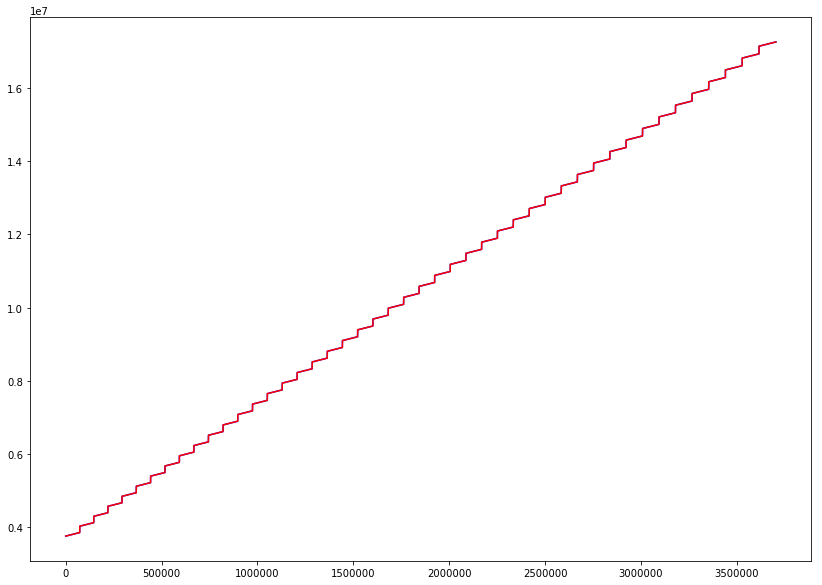

In [31]:
plt.figure(figsize=(14,10))
plt.plot(range(indn.size),indn,'-b',range(indn.size),indc,'-r')
plt.show()